In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
# For preprocessing: Scaling, encoding, handling imbalances
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE  # For oversampling the minority class
from imblearn.under_sampling import RandomUnderSampler  # For undersampling the majority class
from sklearn.impute import SimpleImputer  # For handling missing data
# Supervised Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# For Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
df = pd.read_csv('C:\\Users\\Koushik\\OneDrive\\Desktop\\Fraud.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.corr(numeric_only=True)['isFraud']

step              0.031578
amount            0.076688
oldbalanceOrg     0.010154
newbalanceOrig   -0.008148
oldbalanceDest   -0.005885
newbalanceDest    0.000535
isFraud           1.000000
isFlaggedFraud    0.044109
Name: isFraud, dtype: float64

In [5]:
categorical_columns = []
for column in df.columns:
    if df[column].dtype =='object' or df[column].dtype.name =='category':
        categorical_columns.append(column)

In [6]:
categorical_columns

['type', 'nameOrig', 'nameDest']

In [7]:
from scipy.stats import chi2_contingency

In [8]:
for column in categorical_columns:
    contingency_table = pd.crosstab(df[column],df['isFraud'])
    chi2,p,dof,expected = chi2_contingency(contingency_table)
    print(f"chisquare{column}:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"p-value: {p}")
    print("-" * 50)
    if p < 0.05:
        print(f"There is a significant relationship between {column} and the target variable.\n")
    else:
        print(f"There is no significant relationship between {column} and the target variable.\n")
    

chisquaretype:
Chi2 Statistic: 22082.53571319108
p-value: 0.0
--------------------------------------------------
There is a significant relationship between type and the target variable.

chisquarenameOrig:
Chi2 Statistic: 6351760.166734099
p-value: 0.6676765962260964
--------------------------------------------------
There is no significant relationship between nameOrig and the target variable.

chisquarenameDest:
Chi2 Statistic: 2862093.5233481526
p-value: 0.0
--------------------------------------------------
There is a significant relationship between nameDest and the target variable.



In [9]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

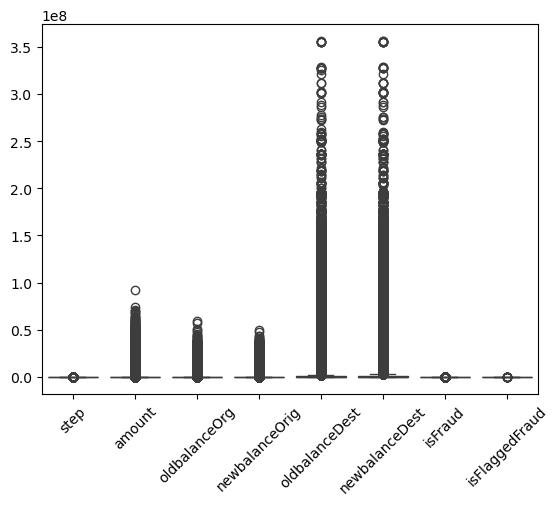

In [10]:
sns.boxplot(data = df)
plt.xticks(rotation=45);

In [11]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

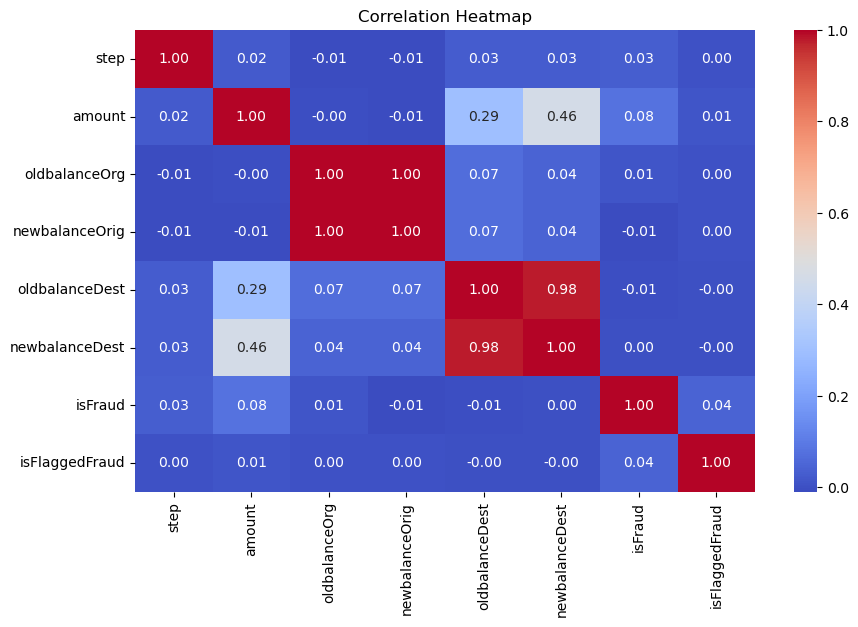

In [12]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [13]:
df = df.drop(columns =['step','isFlaggedFraud'])

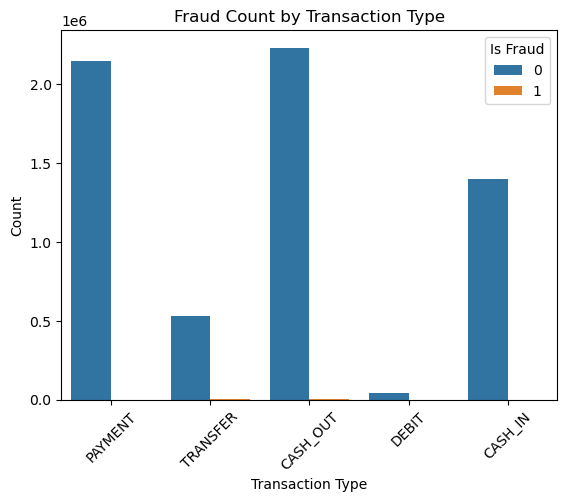

In [14]:
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Count by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is Fraud')
plt.show()


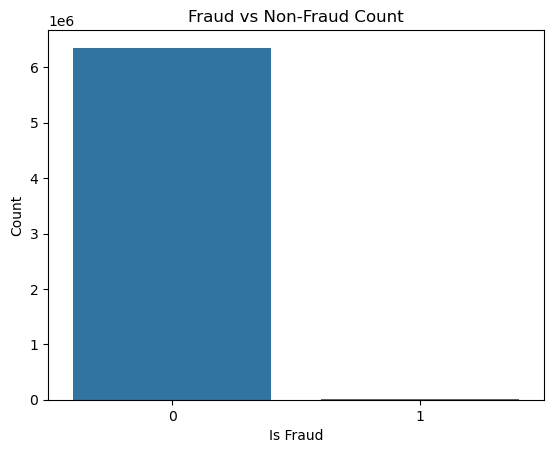

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [15]:
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Count')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

print(df['isFraud'].value_counts(normalize=True) * 100)

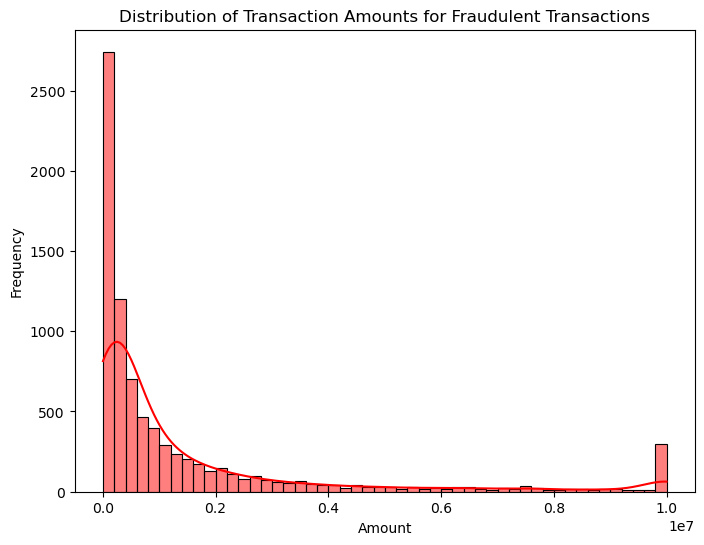

In [16]:
# Filter for fraud transactions only
fraud_data = df[df['isFraud'] == 1]

# Example: Plot amount distribution for fraud transactions
plt.figure(figsize=(8, 6))
sns.histplot(fraud_data['amount'], bins=50, kde=True, color='red')
plt.title('Distribution of Transaction Amounts for Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

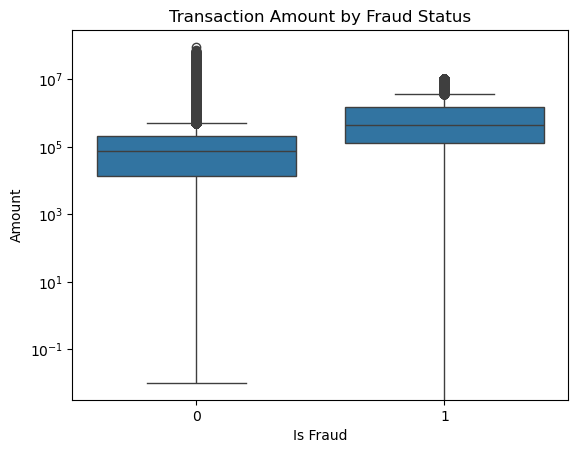

In [17]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.yscale('log')  # Useful if values vary widely
plt.show()


C:\Users\Koushik\AppData\Local\Temp\ipykernel_13424\1289009465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['balanceChangeOrig'] = fraud_df['oldbalanceOrg'] - fraud_df['newbalanceOrig']


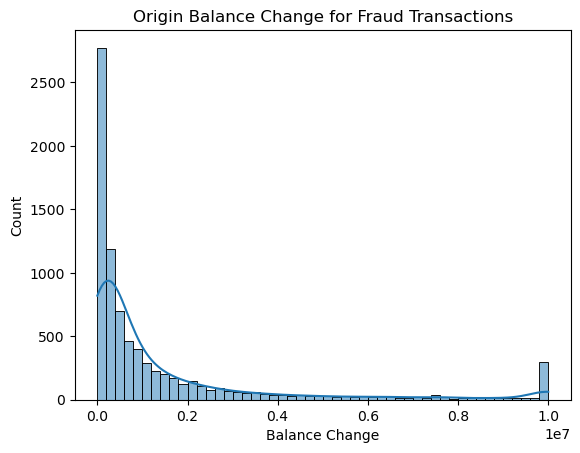

In [18]:
fraud_df = df[df['isFraud'] == 1]
nonfraud_df = df[df['isFraud'] == 0]

# Change in origin balance
fraud_df['balanceChangeOrig'] = fraud_df['oldbalanceOrg'] - fraud_df['newbalanceOrig']
sns.histplot(fraud_df['balanceChangeOrig'], bins=50, kde=True)
plt.title('Origin Balance Change for Fraud Transactions')
plt.xlabel('Balance Change')
plt.ylabel('Count')
plt.show()

In [19]:
# Assuming you have a DataFrame 'df'

# Step 1: Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')  # Use the mean for missing values in numerical columns
df['amount'] = imputer.fit_transform(df[['amount']])  # Example for the 'amount' column

# Step 2: Encode categorical columns (if applicable)
# For example, if 'type' is categorical, let's encode it
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Step 3: Feature scaling (Standardization)
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

In [20]:
# Separate features (X) and target (y)
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])  # Drop non-feature columns
y = df['isFraud']

# Split the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [21]:
# # Importing necessary libraries
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming X_train, X_test, y_train, y_test are already defined after split

# # 1. Apply Random Over-sampling
# ros = RandomOverSampler(random_state=42)
# X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# # 2. Scaling the features for Logistic Regression (since it's sensitive to feature scales)
# scaler = StandardScaler()
# X_train_res = scaler.fit_transform(X_train_res)
# X_test = scaler.transform(X_test)

# # 3. Train Logistic Regression model on the resampled dataset
# logreg = LogisticRegression(random_state=42)
# logreg.fit(X_train_res, y_train_res)

# # 4. Predict on the test data
# y_pred = logreg.predict(X_test)

# # 5. Measure accuracy and precision
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)

# # 6. Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)

# # 7. Plot Confusion Matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
# plt.title('Confusion Matrix for Logistic Regression (Random Over-sampling)')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# # plt.show()

# # 8. Print the results
# print(f"Logistic Regression (Random Over-sampling) Accuracy: {accuracy:.4f}")
# print(f"Logistic Regression (Random Over-sampling) Precision: {precision:.4f}")


Logistic Regression with ROS and Class Weight Precision: 0.0290
Logistic Regression with ROS and Class Weight Recall: 0.8515
Logistic Regression with SMOTE Precision: 0.0298
Logistic Regression with SMOTE Recall: 0.8618


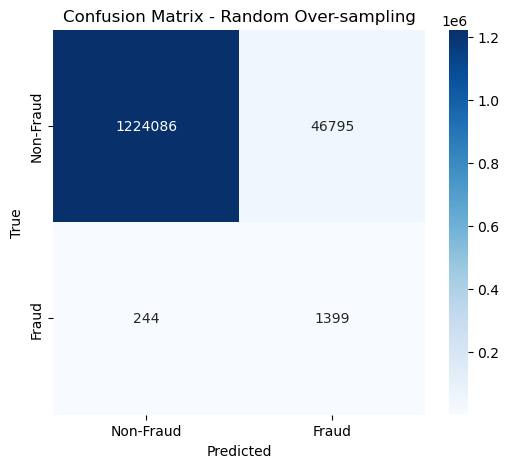

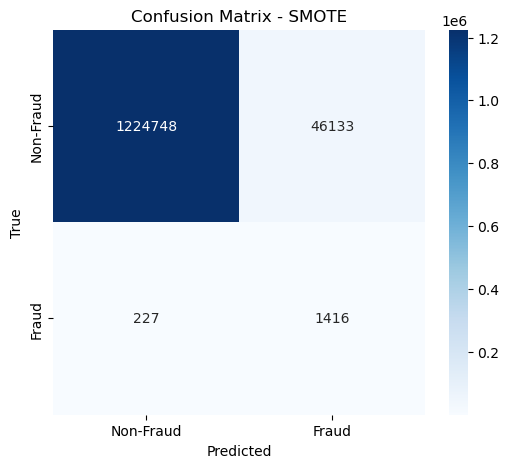

Custom Threshold Precision: 0.0152
Custom Threshold Recall: 0.9355


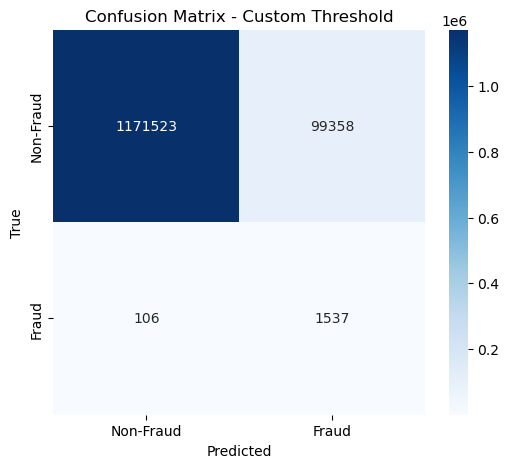

In [22]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming X and y are the features and target columns of your dataset
# # First, split the data into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Scale the features (important for Logistic Regression and other models)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # 1. Apply Random Over-sampling
ros = RandomOverSampler(random_state=42)
X_train_res_ros, y_train_res_ros = ros.fit_resample(X_train, y_train)

# 2. Train Logistic Regression model with class weights (balanced)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train_res_ros, y_train_res_ros)

# 3. Predict on the test data
y_pred = logreg.predict(X_test)

# 4. Evaluate the model with Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# 5. Print Precision and Recall
print(f"Logistic Regression with ROS and Class Weight Precision: {precision:.4f}")
print(f"Logistic Regression with ROS and Class Weight Recall: {recall:.4f}")

# 6. Apply SMOTE for resampling
smote = SMOTE(random_state=42)
X_train_res_smote, y_train_res_smote = smote.fit_resample(X_train, y_train)

# 7. Train Logistic Regression model on SMOTE resampled data
logreg.fit(X_train_res_smote, y_train_res_smote)
y_pred_smote = logreg.predict(X_test)

# 8. Evaluate the model with Precision and Recall for SMOTE
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)

# 9. Print Precision and Recall for SMOTE
print(f"Logistic Regression with SMOTE Precision: {precision_smote:.4f}")
print(f"Logistic Regression with SMOTE Recall: {recall_smote:.4f}")

# 10. Plot Confusion Matrix for both Random Over-sampling and SMOTE
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot Confusion Matrix for ROS
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix - Random Over-sampling")

# Plot Confusion Matrix for SMOTE
plot_confusion_matrix(y_test, y_pred_smote, title="Confusion Matrix - SMOTE")

# 11. Adjust Threshold (for Logistic Regression) to make it more sensitive to fraud
y_prob = logreg.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
threshold = 0.3  # Set a custom threshold, lower than 0.5 to detect more frauds

# Apply custom threshold
y_pred_threshold = (y_prob >= threshold).astype(int)

# Evaluate with custom threshold
precision_threshold = precision_score(y_test, y_pred_threshold)
recall_threshold = recall_score(y_test, y_pred_threshold)

# 12. Print Precision and Recall for Custom Threshold
print(f"Custom Threshold Precision: {precision_threshold:.4f}")
print(f"Custom Threshold Recall: {recall_threshold:.4f}")

# 13. Plot Confusion Matrix for Custom Threshold
plot_confusion_matrix(y_test, y_pred_threshold, title="Confusion Matrix - Custom Threshold")


In [23]:
# # Import necessary libraries
# from sklearn.svm import SVC
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# # from sklearn.preprocessing import StandardScaler
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Ensure the features retain column names after resampling
# X_train_res_ros = pd.DataFrame(X_train_res_ros, columns=X.columns)
# X_train_res_smote = pd.DataFrame(X_train_res_smote, columns=X.columns)

# # 1. Train SVM model with class weights (balanced) on Random Over-sampling data
# svm = SVC(random_state=42, class_weight='balanced', probability=True)  # probability=True for predict_proba
# svm.fit(X_train_res_ros, y_train_res_ros)

# # 2. Predict probabilities on the test data
# y_prob_svm = svm.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)

# # 3. Set a custom threshold for SVM prediction (lower threshold to be more sensitive to fraud)
# threshold_svm = 0.3  # You can adjust this threshold
# y_pred_svm_threshold = (y_prob_svm >= threshold_svm).astype(int)

# # 4. Evaluate Precision and Recall for SVM
# precision_svm = precision_score(y_test, y_pred_svm_threshold)
# recall_svm = recall_score(y_test, y_pred_svm_threshold)

# # 5. Print Precision and Recall for SVM
# print(f"SVM with Custom Threshold Precision: {precision_svm:.4f}")
# print(f"SVM with Custom Threshold Recall: {recall_svm:.4f}")

# # 6. Plot Confusion Matrix for SVM
# def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
#     plt.title(title)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()

# # Plot Confusion Matrix for SVM
# plot_confusion_matrix(y_test, y_pred_svm_threshold, title="Confusion Matrix - SVM")

# # 7. Experiment with a different threshold (e.g., 0.2 or 0.1)
# threshold_svm_2 = 0.2
# y_pred_svm_threshold_2 = (y_prob_svm >= threshold_svm_2).astype(int)

# # 8. Evaluate Precision and Recall for the new threshold
# precision_svm_2 = precision_score(y_test, y_pred_svm_threshold_2)
# recall_svm_2 = recall_score(y_test, y_pred_svm_threshold_2)

# # 9. Print Precision and Recall for new threshold
# print(f"SVM with Threshold 0.2 Precision: {precision_svm_2:.4f}")
# print(f"SVM with Threshold 0.2 Recall: {recall_svm_2:.4f}")

# # 10. Plot Confusion Matrix for SVM with threshold 0.2
# plot_confusion_matrix(y_test, y_pred_svm_threshold_2, title="Confusion Matrix - SVM (Threshold 0.2)")


C:\Users\Koushik\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost with Threshold 0.3 Precision: 0.1716
XGBoost with Threshold 0.3 Recall: 0.9945


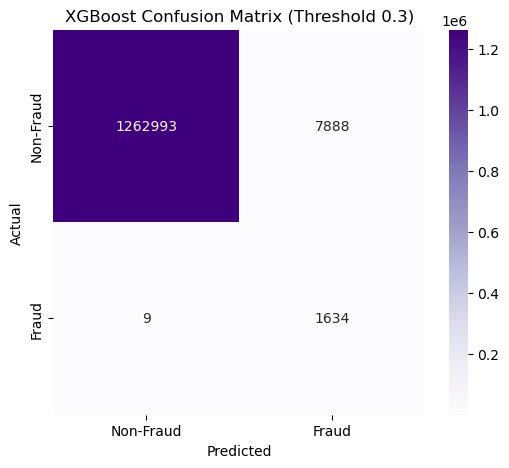

XGBoost with Threshold 0.2 Precision: 0.1480
XGBoost with Threshold 0.2 Recall: 0.9951


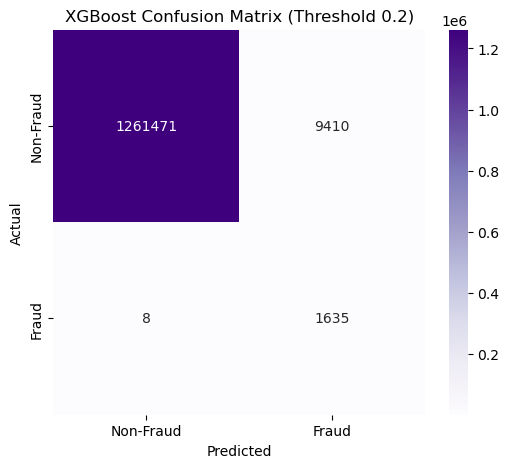

In [24]:
# Import XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: If needed, fix feature names after sampling
X_train_res_ros = pd.DataFrame(X_train_res_ros, columns=X.columns)

# 1. Train XGBoost model on ROS sampled data
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res_ros, y_train_res_ros)

# 2. Predict probabilities on the test set
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 3. Apply custom threshold
threshold_xgb = 0.3  # You can try different thresholds
y_pred_xgb = (y_prob_xgb >= threshold_xgb).astype(int)

# 4. Evaluate performance
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

print(f"XGBoost with Threshold {threshold_xgb} Precision: {precision_xgb:.4f}")
print(f"XGBoost with Threshold {threshold_xgb} Recall: {recall_xgb:.4f}")

# 5. Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred_xgb, title=f"XGBoost Confusion Matrix (Threshold {threshold_xgb})")

# 6. Optional: Try another threshold
threshold_alt = 0.2
y_pred_alt = (y_prob_xgb >= threshold_alt).astype(int)
precision_alt = precision_score(y_test, y_pred_alt)
recall_alt = recall_score(y_test, y_pred_alt)

print(f"XGBoost with Threshold {threshold_alt} Precision: {precision_alt:.4f}")
print(f"XGBoost with Threshold {threshold_alt} Recall: {recall_alt:.4f}")
plot_confusion_matrix(y_test, y_pred_alt, title=f"XGBoost Confusion Matrix (Threshold {threshold_alt})")


In [25]:
# # Import
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Optional: Make sure your training data has column names (for readability)
# X_train_res_ros = pd.DataFrame(X_train_res_ros, columns=X.columns)

# # 1. Train Random Forest model
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train_res_ros, y_train_res_ros)

# # 2. Predict probabilities on the test set
# # y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# # 3. Apply a custom threshold
# threshold_rf = 0.3  # You can try different thresholds
# y_pred_rf = (y_prob_rf >= threshold_rf).astype(int)

# # 4. Evaluate performance
# precision_rf = precision_score(y_test, y_pred_rf)
# recall_rf = recall_score(y_test, y_pred_rf)

# print(f"Random Forest with Threshold {threshold_rf} Precision: {precision_rf:.4f}")
# print(f"Random Forest with Threshold {threshold_rf} Recall: {recall_rf:.4f}")

# # 5. Plot Confusion Matrix
# def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
#     plt.title(title)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()

# plot_confusion_matrix(y_test, y_pred_rf, title=f"Random Forest Confusion Matrix (Threshold {threshold_rf})")

# # 6. Optional: Try another threshold
# threshold_alt = 0.2
# y_pred_alt_rf = (y_prob_rf >= threshold_alt).astype(int)
# precision_alt_rf = precision_score(y_test, y_pred_alt_rf)
# recall_alt_rf = recall_score(y_test, y_pred_alt_rf)

# print(f"Random Forest with Threshold {threshold_alt} Precision: {precision_alt_rf:.4f}")
# print(f"Random Forest with Threshold {threshold_alt} Recall: {recall_alt_rf:.4f}")
# plot_confusion_matrix(y_test, y_pred_alt_rf, title=f"Random Forest Confusion Matrix (Threshold {threshold_alt})")


In [26]:

# pip install lightgbm

[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📘 LightGBM with ROS
Precision: 0.1957223085195364
Recall: 0.996956786366403


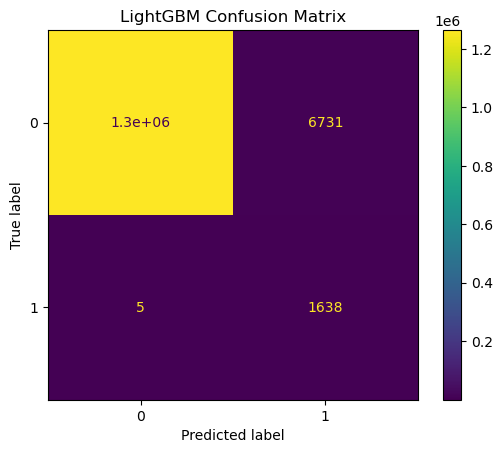

In [27]:
# 📦 Import Required Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# 🧹 Optional: Preprocessing steps assumed done (e.g., feature selection, encoding)

# 🎯 Split original data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# 🔄 Apply Random Oversampling (ROS)
ros = RandomOverSampler(random_state=42)
X_train_res_ros, y_train_res_ros = ros.fit_resample(X_train, y_train)

# 🚀 Train LightGBM Model
lgb_model = LGBMClassifier(is_unbalance=True, random_state=42)
lgb_model.fit(X_train_res_ros, y_train_res_ros)

# 🔍 Predict probabilities and apply custom threshold
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
y_pred_lgb = (y_prob_lgb >= 0.3).astype(int)

# 📊 Evaluation metrics
print("📘 LightGBM with ROS")
print("Precision:", precision_score(y_test, y_pred_lgb))
print("Recall:", recall_score(y_test, y_pred_lgb))

# 📉 Confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp.plot()
plt.title("LightGBM Confusion Matrix")
plt.show()


In [28]:
# # 📦 Import Required Libraries
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import RandomOverSampler
# from lightgbm import LGBMClassifier
# import matplotlib.pyplot as plt

# # 1. Load your data (assume df is already loaded)
# # df = pd.read_csv("creditcard.csv")  # Replace with your dataset

# # 2. Preprocessing
# X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])  # Drop target + non-numeric columns
# y = df['isFraud']

# # Optional: scale numeric features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# # 4. Apply Random Oversampling
# ros = RandomOverSampler(random_state=42)
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# # 5. LightGBM Hyperparameter Tuning
# lgb = LGBMClassifier(random_state=42, is_unbalance=True)

# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.05, 0.1],
#     'max_depth': [6, 10],
#     'num_leaves': [31, 50]
# }

# grid = GridSearchCV(lgb, param_grid, cv=3, scoring='recall', n_jobs=-1)
# grid.fit(X_train_ros, y_train_ros)

# best_lgb = grid.best_estimator_

# # 6. Predict with custom threshold
# y_probs = best_lgb.predict_proba(X_test)[:, 1]

# # Search best threshold manually or visually
# threshold = 0.4
# y_pred = (y_probs >= threshold).astype(int)

# # 7. Evaluation
# print("📘 LightGBM (Fine-tuned) with ROS")
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # 8. Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.title("Confusion Matrix - LightGBM (Fine-tuned)")
# plt.show()


[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📘 LightGBM with ROS (Tuned, No GridSearch)
Precision: 0.37720111214087115
Recall: 0.9908703590992087

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.38      0.99      0.55      1643

    accuracy                           1.00   1272524
   macro avg       0.69      0.99      0.77   1272524
weighted avg       1.00      1.00      1.00   1272524



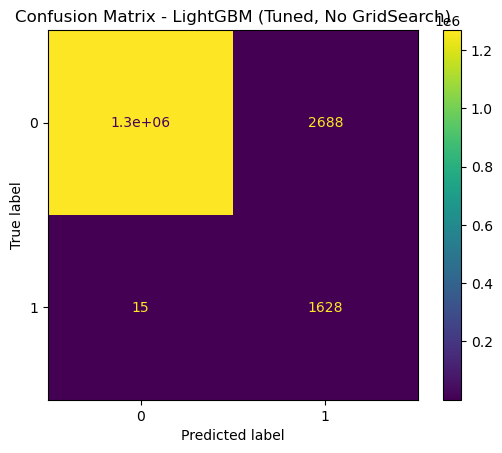

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# 5. LightGBM Classifier - Manually Tuned
lgb_model = LGBMClassifier(
    random_state=42,
    is_unbalance=True,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    num_leaves=40
)
lgb_model.fit(X_train_ros, y_train_ros)

# 6. Predict probabilities and apply threshold
y_probs = lgb_model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred = (y_probs >= threshold).astype(int)

# 7. Evaluation
print("📘 LightGBM with ROS (Tuned, No GridSearch)")
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 8. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - LightGBM (Tuned, No GridSearch)")
plt.show()

In [30]:
import joblib
import os

# Define the folder and filename where the model will be saved
model_folder = 'fraud_model'
model_filename = os.path.join(model_folder, 'lightgbm_fraud_model.pkl')

# Create the directory if it doesn't exist
os.makedirs(model_folder, exist_ok=True)

# Save the trained model to the file
joblib.dump(lgb_model, model_filename)

print(f"Model successfully saved at {model_filename}")


Model successfully saved at fraud_model\lightgbm_fraud_model.pkl


In [61]:
import os
print(os.getcwd())


C:\Users\Koushik


In [65]:
import os

folder_path = os.path.abspath("fraud_model")
print("📂 Full path to the folder:", folder_path)


📂 Full path to the folder: C:\Users\Koushik\fraud_model


In [71]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,3,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0
1,3,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0
2,4,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1
3,1,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1
4,3,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0
